In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer 

from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

import string
from matplotlib.ticker import MaxNLocator

from wordcloud import WordCloud
from PIL import Image


nltk.download('stopwords')
stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/brettzimmerman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
harvey = pd.read_csv('harvey.tsv', sep='\t')
irma = pd.read_csv('irma.tsv', sep='\t')
matthew = pd.read_csv('matthew.tsv', sep='\t')
maria = pd.read_csv('maria.tsv', sep='\t')

In [3]:
harvey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6378 entries, 0 to 6377
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   tweet_id     6378 non-null   int64 
 1   tweet_text   6378 non-null   object
 2   class_label  6378 non-null   object
dtypes: int64(1), object(2)
memory usage: 149.6+ KB


In [4]:
irma.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6579 entries, 0 to 6578
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   tweet_id     6579 non-null   int64 
 1   tweet_text   6579 non-null   object
 2   class_label  6579 non-null   object
dtypes: int64(1), object(2)
memory usage: 154.3+ KB


In [5]:
maria.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5094 entries, 0 to 5093
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   tweet_id     5094 non-null   int64 
 1   tweet_text   5094 non-null   object
 2   class_label  5094 non-null   object
dtypes: int64(1), object(2)
memory usage: 119.5+ KB


In [6]:
maria['class_label'].value_counts()

rescue_volunteering_or_donation_effort    1384
other_relevant_information                1097
infrastructure_and_utility_damage          999
requests_or_urgent_needs                   498
sympathy_and_support                       470
injured_or_dead_people                     211
not_humanitarian                           189
caution_and_advice                         154
displaced_people_and_evacuations            92
Name: class_label, dtype: int64

In [7]:
harvey['class_label'].value_counts()

rescue_volunteering_or_donation_effort    1976
other_relevant_information                1237
infrastructure_and_utility_damage          852
injured_or_dead_people                     488
displaced_people_and_evacuations           482
sympathy_and_support                       444
caution_and_advice                         379
not_humanitarian                           287
requests_or_urgent_needs                   233
Name: class_label, dtype: int64

In [8]:
matthew['class_label'].value_counts()

sympathy_and_support                      276
other_relevant_information                229
rescue_volunteering_or_donation_effort    228
injured_or_dead_people                    157
infrastructure_and_utility_damage         125
not_humanitarian                           53
requests_or_urgent_needs                   37
displaced_people_and_evacuations           27
caution_and_advice                         25
Name: class_label, dtype: int64

In [9]:
#relief = displaced_people_and_evacuations, rescue_volunteering_or_donation_effort, caution_and_advice
#danger = injured_or_dead_people, infrastructure_and_utility_damage
#emergencies = requests_or_urgent_needs

In [10]:
maria[maria['class_label'] == 'other_relevant_information']

,tweet_id,tweet_text,class_label
0,914134332226330625,San Juan: Trump lashes out with good reason. #...,other_relevant_information
15,913047145225375745,From the South: .@EduardomteleSUR: Some commun...,other_relevant_information
17,913171275190870016,"RING THE ISLAND WITH NAVAL VESSELS, A/C CARRIE...",other_relevant_information
18,912413151571972096,Puerto Rico Hurricane Maria Relief Fund M&amp;...,other_relevant_information
20,914642411854458880,MAKE IT VIRAL. PR Mayor blocking FOOD- TEARFUL...,other_relevant_information
...,...,...,...
5078,913048452384329728,RT @AprilHathcock: .@realDonaldTrump SEND AID ...,other_relevant_information
5083,913941801777610752,RT @SarahNEmerson: EPA says it found no signif...,other_relevant_information
5086,911988002506838016,"#DSTRShelterOffered Take a knee, boat, supplie...",other_relevant_information
5089,914344693625843719,Hurricane Maria was forecast w/hourly updates....,other_relevant_information


In [11]:
hurricanes = pd.concat([harvey, irma, matthew, maria])

In [12]:
hurricanes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19208 entries, 0 to 5093
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   tweet_id     19208 non-null  int64 
 1   tweet_text   19208 non-null  object
 2   class_label  19208 non-null  object
dtypes: int64(1), object(2)
memory usage: 600.2+ KB


In [13]:
hurricanes['class_label'].value_counts()

rescue_volunteering_or_donation_effort    4701
other_relevant_information                4214
infrastructure_and_utility_damage         3293
sympathy_and_support                      1587
injured_or_dead_people                    1482
displaced_people_and_evacuations          1129
caution_and_advice                         987
not_humanitarian                           959
requests_or_urgent_needs                   856
Name: class_label, dtype: int64

In [14]:
hurricanes['class_label'] = hurricanes['class_label'].replace({'displaced_people_and_evacuations': 'relief'})
hurricanes['class_label'] = hurricanes['class_label'].replace({'rescue_volunteering_or_donation_effort': 'relief'})
hurricanes['class_label'] = hurricanes['class_label'].replace({'caution_and_advice': 'relief'})

hurricanes['class_label'] = hurricanes['class_label'].replace({'injured_or_dead_people': 'danger'})
hurricanes['class_label'] = hurricanes['class_label'].replace({'infrastructure_and_utility_damage': 'danger'})

hurricanes['class_label'] = hurricanes['class_label'].replace({'requests_or_urgent_needs': 'emergency'})

hurricanes['class_label'] = hurricanes['class_label'].replace({'other_relevant_information': 'other'})
hurricanes['class_label'] = hurricanes['class_label'].replace({'sympathy_and_support': 'other'})
hurricanes['class_label'] = hurricanes['class_label'].replace({'not_humanitarian': 'other'})

In [15]:
hurricanes['class_label'].value_counts()

relief       6817
other        6760
danger       4775
emergency     856
Name: class_label, dtype: int64

In [16]:
hurricanes

,tweet_id,tweet_text,class_label
0,903388763073720321,"Hurricane Harvey killed at least 38 people, bu...",danger
1,901136425348759552,Harvey upped to Category 2 hurricane with 110+...,other
2,902853707607535616,A huge shoutout @TexasGuard for all the work y...,relief
3,902859729701044224,Our thoughts and prayers are with the people h...,other
4,901405975856414720,Homes destroyed on Broadway St in Rockport. Pe...,danger
...,...,...,...
5089,914344693625843719,Hurricane Maria was forecast w/hourly updates....,other
5090,913357132833198080,The worst hit areas of #PuertoRico in the wake...,other
5091,913169413607612416,US sends more aid to Puerto Rico following Hur...,danger
5092,910795560281608192,Hurricane Maria path update LIVE: Maria lashes...,danger


In [17]:
le = LabelEncoder()
le.fit(hurricanes['class_label'])
hurricanes['label'] = le.transform(hurricanes['class_label'])
hurricanes.head()

,tweet_id,tweet_text,class_label,label
0,903388763073720321,"Hurricane Harvey killed at least 38 people, bu...",danger,0
1,901136425348759552,Harvey upped to Category 2 hurricane with 110+...,other,2
2,902853707607535616,A huge shoutout @TexasGuard for all the work y...,relief,3
3,902859729701044224,Our thoughts and prayers are with the people h...,other,2
4,901405975856414720,Homes destroyed on Broadway St in Rockport. Pe...,danger,0


In [18]:
hurricanes['label'].value_counts(normalize=True)

3    0.354904
2    0.351937
0    0.248594
1    0.044565
Name: label, dtype: float64

In [19]:
new_stopwords = ['hurricane', 'harvey', 'irma', 'matthew', 'maria', 'hurricaneharvey', 'hurricanemaria', 'hurricaneirma']
punctuations = string.punctuation
stopwords.extend(new_stopwords)
stopwords.extend(punctuations)

In [20]:
hurricanes

,tweet_id,tweet_text,class_label,label
0,903388763073720321,"Hurricane Harvey killed at least 38 people, bu...",danger,0
1,901136425348759552,Harvey upped to Category 2 hurricane with 110+...,other,2
2,902853707607535616,A huge shoutout @TexasGuard for all the work y...,relief,3
3,902859729701044224,Our thoughts and prayers are with the people h...,other,2
4,901405975856414720,Homes destroyed on Broadway St in Rockport. Pe...,danger,0
...,...,...,...,...
5089,914344693625843719,Hurricane Maria was forecast w/hourly updates....,other,2
5090,913357132833198080,The worst hit areas of #PuertoRico in the wake...,other,2
5091,913169413607612416,US sends more aid to Puerto Rico following Hur...,danger,0
5092,910795560281608192,Hurricane Maria path update LIVE: Maria lashes...,danger,0


In [21]:
import re
#Create a function to clean the Tweets with Regex
def remove_junk(text):
    text = re.sub(r'@[A-Za-z0-9#]+', '', str(text)) #remove @mentions 
    text = re.sub(r'RT[\s]+', '', str(text)) # remove RT
    #text = re.sub(r'\[VIDEO\]', '', str(text)) # remove [VIDEO] describer
    #text = re.sub(r'\{link\}', '', str(text)) # remove {link} describer
    text = re.sub(r'https?:\/\/\S+', '', text) # removes actual links
    text = re.sub(r'#', '', str(text)) # remove hashtag symbol
    #text = re.sub(r'&quot', '', str(text)) # remove quote symbol
    #text = re.sub(r'&amp', '', str(text)) # remove and symbol
    return text

In [22]:
def tokenize(text):
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    tokenized_tweet = regex_token.tokenize(text)
    tweet_tokens = [word.lower() for word in tokenized_tweet]
    return tweet_tokens

In [23]:
def remove_sw_punct(tweet_tokens):
    tweets_clean = [word for word in tweet_tokens if word not in stopwords]
    return tweets_clean

In [24]:
stemmer = PorterStemmer()

def stemming(tweets_clean):
    tweets_stem = [stemmer.stem(token) for token in tweets_clean]         
    return tweets_stem

In [79]:
lemmatizer = WordNetLemmatizer()

def lemma(tweets_clean):
    tweets_lemma = [lemmatizer.lemmatize(token) for token in tweets_clean]         
    return tweets_lemma

In [25]:
#Combining the preprocessing into a function
def process_tweet(text):
    processed_tweet = remove_junk(text)
    tweet_tokens = tokenize(processed_tweet)
    tweets_clean = remove_sw_punct(tweet_tokens)
    tweets_stem = stemming(tweets_clean)
    return tweets_stem

In [95]:
from textblob import TextBlob
 
# POS_TAGGER_LEMMA_FUNCTION
def pos_tagger(sentence):
    sent = TextBlob(sentence)
    tag_dict = {"J": 'a', "N": 'n', "V": 'v', "R": 'r'}
    words_tags = [(w, tag_dict.get(pos[0], 'n')) for w, pos in sent.tags]   
    lemma_list = [wd.lemmatize(tag) for wd, tag in words_tags]
    return lemma_list
 

In [110]:
#Combining the preprocessing into a function
def lemma_tweet(text):
    processed_tweet = remove_junk(text)
    tweet_tokens = pos_tagger(processed_tweet)
    tweet_lemma = [word.lower() for word in tweet_tokens]
    #tweets_clean = remove_sw_punct(tweet_tokens)
    #tweets_lemma = lemma(tweets_clean)
    tweets_lemma = ' '.join(tweet_lemma)
    return tweets_lemma

In [111]:
#hurricanes['model_text_lemma'] = hurricanes['tweet_text'].apply(lemma_tweet)

In [112]:
hurricanes['processed_tweet'] = hurricanes['tweet_text'].apply(process_tweet)
hurricanes['model_text'] = hurricanes['tweet_text'].apply(remove_junk)
hurricanes['model_text_lemma'] = hurricanes['tweet_text'].apply(lemma_tweet)

In [113]:
hurricanes

,tweet_id,tweet_text,class_label,label,processed_tweet,model_text,model_text_lemma
0,903388763073720321,"Hurricane Harvey killed at least 38 people, bu...",danger,0,"[kill, least, peopl, charli, hebdo, mag, say, ...","Hurricane Harvey killed at least 38 people, bu...",hurricane harvey kill at least 38 people but c...
1,901136425348759552,Harvey upped to Category 2 hurricane with 110+...,other,2,"[up, categori, mph, wind, flood, expect]",Harvey upped to Category 2 hurricane with 110+...,harvey up to category 2 hurricane with 110+ mp...
2,902853707607535616,A huge shoutout @TexasGuard for all the work y...,relief,3,"[huge, shoutout, work, usarmi, soldier, help, ...",A huge shoutout for all the work your USArmy ...,a huge shoutout for all the work your usarmy s...
3,902859729701044224,Our thoughts and prayers are with the people h...,other,2,"[thought, prayer, peopl, hit, know, fellow, ma...",Our thoughts and prayers are with the people h...,our thought and prayer be with the people hit ...
4,901405975856414720,Homes destroyed on Broadway St in Rockport. Pe...,danger,0,"[home, destroy, broadway, st, rockport, peopl,...",Homes destroyed on Broadway St in Rockport. Pe...,homes destroy on broadway st in rockport peopl...
...,...,...,...,...,...,...,...
5089,914344693625843719,Hurricane Maria was forecast w/hourly updates....,other,2,"[forecast, w, hourli, updat, surpris, could, s...",Hurricane Maria was forecast w/hourly updates....,hurricane maria be forecast w/hourly update no...
5090,913357132833198080,The worst hit areas of #PuertoRico in the wake...,other,2,"[worst, hit, area, puertorico, wake]",The worst hit areas of PuertoRico in the wake ...,the bad hit area of puertorico in the wake of ...
5091,913169413607612416,US sends more aid to Puerto Rico following Hur...,danger,0,"[us, send, aid, puerto, rico, follow, maria, d...",US sends more aid to Puerto Rico following Hur...,us send more aid to puerto rico follow hurrica...
5092,910795560281608192,Hurricane Maria path update LIVE: Maria lashes...,danger,0,"[path, updat, live, lash, dominican, republ, p...",Hurricane Maria path update LIVE: Maria lashes...,hurricane maria path update live maria lash do...


Text(0.5, 0, 'Sentiment Class')

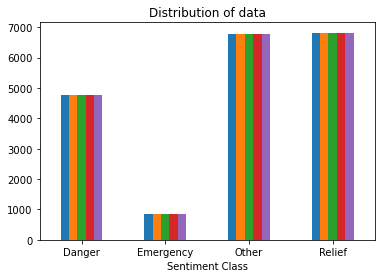

In [38]:
# Plotting the distribution for dataset.
ax = hurricanes.groupby('class_label').count().plot(kind='bar', title='Distribution of data', legend=False)
ax.set_xticklabels(['Danger','Emergency', 'Other', 'Relief'], rotation=0)
ax.set_xlabel('Sentiment Class')

In [45]:
def create_wordcloud(sentiment, color):
    sent_class = hurricanes['processed_tweet'].loc[hurricanes['class_label'] == sentiment]

    sentiment_words = []
    for i in sent_class:
        listToStr = ' '.join(map(str, i))
        sentiment_words.append(listToStr)
    sentiment_words = ' '.join(map(str,  sentiment_words))

    # instantiate a word cloud object
    wc = WordCloud(
        background_color='white',
        max_words=2000,
        colormap=color
        )
    # generate the word cloud
    wc.generate(sentiment_words)

    plt.figure(figsize=(12,10))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()

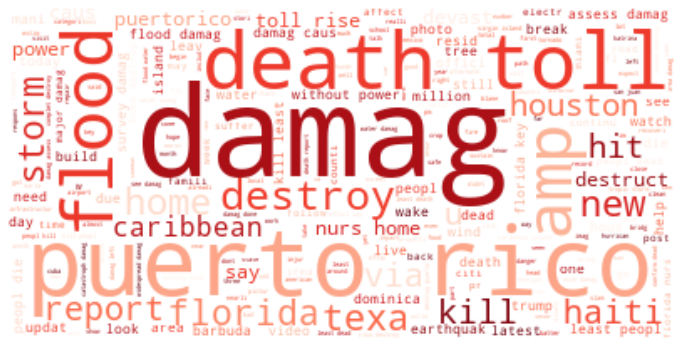

In [46]:
create_wordcloud('danger', 'Reds')

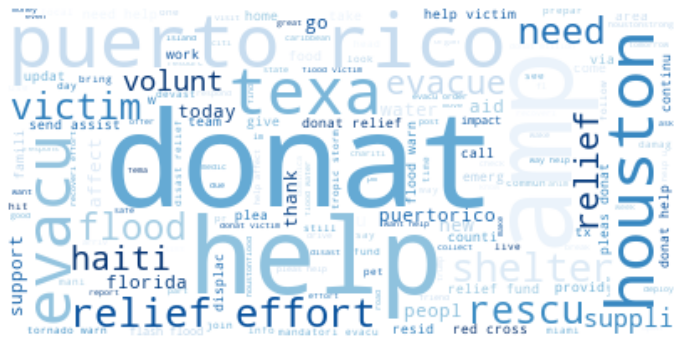

In [47]:
create_wordcloud('relief', 'Blues')

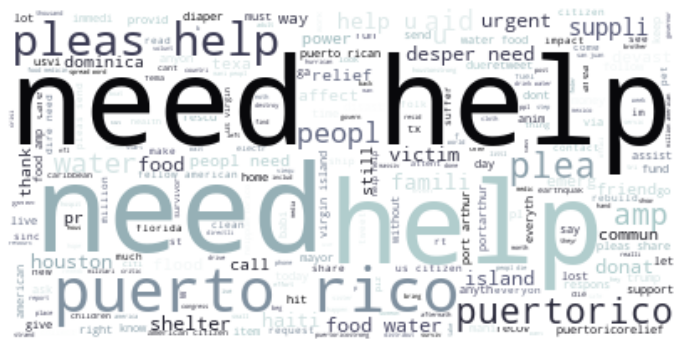

In [48]:
create_wordcloud('emergency', 'bone')

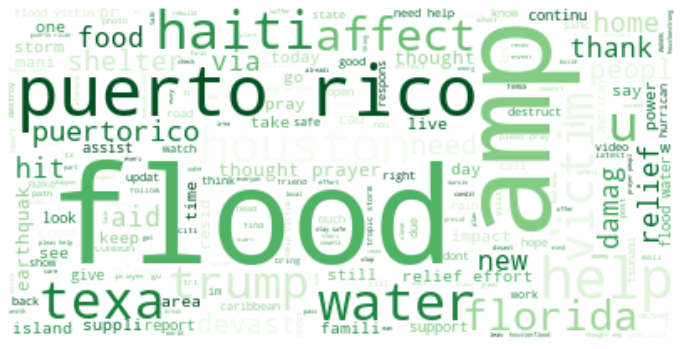

In [54]:
create_wordcloud('other', 'Greens')

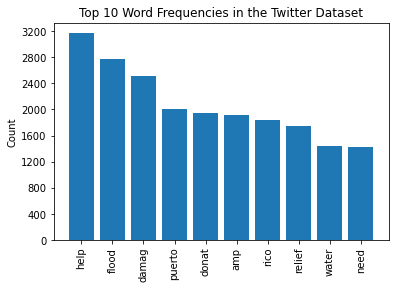

In [31]:
def visualize_top_10(freq_dist, title):

    # Extract data for plotting
    top_10 = list(zip(*freq_dist.most_common(10)))
    tokens = top_10[0]
    counts = top_10[1]

    # Set up plot and plot data
    fig, ax = plt.subplots()
    ax.bar(tokens, counts)

    # Customize plot appearance
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=90)
    
freq_dist = FreqDist(hurricanes['processed_tweet'].explode())

# Plot the top 10 tokens
visualize_top_10(freq_dist, "Top 10 Word Frequencies in the Twitter Dataset")

# Train Test Split

In [114]:
X = hurricanes.drop('label', axis=1)
y = hurricanes['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, train_size = .8)

In [115]:
X_train

,tweet_id,tweet_text,class_label,processed_tweet,model_text,model_text_lemma
5888,909412435907321856,@SheriffClarke I thought the clinton foundatio...,other,"[thought, clinton, foundat, found, help, reall...",I thought the clinton foundation was founded ...,i think the clinton foundation be found to hel...
4984,909386224481325057,"After being devastated by Hurricane Irma, the ...",other,"[devast, peopl, barbuda, need, help, ever, ple...","After being devastated by Hurricane Irma, the ...",after be devastate by hurricane irma the peopl...
3719,909445717336485888,Irmas #Damage a #Reminder of #Florida economys...,danger,"[irma, damag, remind, florida, economi, econom...",Irmas Damage a Reminder of Florida economys - ...,irmas damage a reminder of florida economy eco...
5848,902599618495741956,"LATEST: FEMA has moved 2.9 million meals, 2.8 ...",relief,"[latest, fema, move, million, meal, million, l...","LATEST: FEMA has moved 2.9 million meals, 2.8 ...",latest fema have move 2.9 million meal 2.8 mil...
3047,902903802193424384,Not sure if your food is safe after #Harvey? D...,relief,"[sure, food, safe, dont, risk, get, sick, call...",Not sure if your food is safe after Harvey? Do...,not sure if your food be safe after harvey don...
...,...,...,...,...,...,...
360,783481400410382336,RT @greedybea: praying for haiti and every pla...,other,"[pray, haiti, everi, place, affect, mayb, evac...",: praying for haiti and every place that is be...,praying for haiti and every place that be be a...
4948,913781477707538432,"#ICYMI, a roundup of this weeks major #firefig...",other,"[icymi, roundup, week, major, firefight, rescu...","ICYMI, a roundup of this weeks major firefight...",icymi a roundup of this week major firefightin...
4929,907920501225525249,HUFFPOST: .IMKristenBell rode out #HurricaneIr...,relief,"[huffpost, imkristenbel, rode, florida, sing, ...",HUFFPOST: .IMKristenBell rode out HurricaneIrm...,huffpost .imkristenbell ride out hurricaneirma...
4045,912130508926128128,Millions of Americans in Puerto Rico need help...,emergency,"[million, american, puerto, rico, need, help, ...",Millions of Americans in Puerto Rico need help...,millions of americans in puerto rico need help...


# Baseline Model Dummy Classifier

In [33]:
dum_pipe = Pipeline([('count', CountVectorizer()),
                    ('model', DummyClassifier(strategy='stratified'))])

model = dum_pipe.fit(X_train['model_text'], y_train)

y_trn_pred = dum_pipe.predict(X_train['model_text'])
y_tst_pred = dum_pipe.predict(X_test['model_text'])
    
print('\t\tThe Train Results')
print(classification_report(y_train, y_trn_pred))
print('\n\t\tThe Test Results')
print(classification_report(y_test, y_tst_pred))

		The Train Results
              precision    recall  f1-score   support

           0       0.25      0.26      0.25      3820
           1       0.05      0.05      0.05       685
           2       0.36      0.36      0.36      5408
           3       0.36      0.36      0.36      5453

    accuracy                           0.32     15366
   macro avg       0.25      0.25      0.25     15366
weighted avg       0.32      0.32      0.32     15366


		The Test Results
              precision    recall  f1-score   support

           0       0.26      0.25      0.26       955
           1       0.03      0.04      0.03       171
           2       0.36      0.36      0.36      1352
           3       0.35      0.36      0.36      1364

    accuracy                           0.32      3842
   macro avg       0.25      0.25      0.25      3842
weighted avg       0.32      0.32      0.32      3842



In [34]:
tf_nb_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords, tokenizer=tokenize)),
    ('smt', SMOTE(random_state=30)),
    ('mnb', MultinomialNB()),
])
parameters = {
    'tfidf__max_df': (0.25, 0.75, 0.90),
    'tfidf__min_df': (2, 3),
    'tfidf__ngram_range': [(1,1),(1, 2), (1, 3)],
    'tfidf__max_features': (10000, 70000, 85000),
    'tfidf__norm': ('l1', 'l2'),
    'mnb__alpha': (.005, .05, .5),
    'smt__k_neighbors' : (2,5)
    
}

grid_search = GridSearchCV(tf_nb_pipe, parameters, cv=2, n_jobs=2, verbose=3, scoring = 'f1_macro')
grid_search.fit(X_train['model_text'], y_train)

tf_nb_best = grid_search.best_estimator_

y_trn_pred = tf_nb_best.predict(X_train['model_text'])
y_tst_pred = tf_nb_best.predict(X_test['model_text'])
    
print('\t\tThe Train Results')
print(classification_report(y_train, y_trn_pred))
print('\n\t\tThe Test Results')
print(classification_report(y_test, y_tst_pred))

Fitting 2 folds for each of 648 candidates, totalling 1296 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   11.4s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   47.2s
[Parallel(n_jobs=2)]: Done 284 tasks      | elapsed:  2.2min
[Parallel(n_jobs=2)]: Done 508 tasks      | elapsed:  3.9min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  5.8min
[Parallel(n_jobs=2)]: Done 1148 tasks      | elapsed:  8.6min
[Parallel(n_jobs=2)]: Done 1296 out of 1296 | elapsed:  9.6min finished


		The Train Results
              precision    recall  f1-score   support

           0       0.85      0.92      0.88      3820
           1       0.47      0.97      0.64       685
           2       0.85      0.73      0.78      5408
           3       0.86      0.82      0.84      5453

    accuracy                           0.82     15366
   macro avg       0.76      0.86      0.79     15366
weighted avg       0.84      0.82      0.82     15366


		The Test Results
              precision    recall  f1-score   support

           0       0.77      0.85      0.81       955
           1       0.34      0.74      0.46       171
           2       0.73      0.61      0.66      1352
           3       0.77      0.72      0.74      1364

    accuracy                           0.72      3842
   macro avg       0.65      0.73      0.67      3842
weighted avg       0.74      0.72      0.72      3842



In [49]:
tf_nb_best

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.25, max_features=10000, min_df=3,
                                 ngram_range=(1, 3),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 tokenizer=<function tokenize at 0x15bb3f8b0>)),
                ('smt', SMOTE(random_state=30)),
                ('mnb', MultinomialNB(alpha=0.5))])

In [126]:
tf_nb_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=tokenize, stop_words=stopwords)),
    ('smt', SMOTE(random_state=30)),
    ('mnb', MultinomialNB()),
])
parameters = {
    'tfidf__max_df': (0.25, 0.5),
    'tfidf__min_df': (2, 3),
    'tfidf__ngram_range': [(1,1),(1, 2), (1, 3)],
    'tfidf__max_features': (10000, 85000),
    'mnb__alpha': (.005, .05),
    'smt__k_neighbors' : (2,5)
    
}

grid_search = GridSearchCV(tf_nb_pipe, parameters, cv=2, n_jobs=2, verbose=3, scoring = 'f1_macro')
grid_search.fit(X_train['model_text_lemma'], y_train)

tf_nb_best = grid_search.best_estimator_

y_trn_pred = tf_nb_best.predict(X_train['model_text_lemma'])
y_tst_pred = tf_nb_best.predict(X_test['model_text_lemma'])
    
print('\t\tThe Train Results')
print(classification_report(y_train, y_trn_pred))
print('\n\t\tThe Test Results')
print(classification_report(y_test, y_tst_pred))

Fitting 2 folds for each of 96 candidates, totalling 192 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   10.8s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   47.4s
[Parallel(n_jobs=2)]: Done 192 out of 192 | elapsed:  1.2min finished


		The Train Results
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      3820
           1       0.61      0.96      0.75       685
           2       0.87      0.77      0.82      5408
           3       0.87      0.86      0.87      5453

    accuracy                           0.85     15366
   macro avg       0.80      0.88      0.83     15366
weighted avg       0.86      0.85      0.85     15366


		The Test Results
              precision    recall  f1-score   support

           0       0.77      0.82      0.80       955
           1       0.34      0.57      0.42       171
           2       0.70      0.65      0.67      1352
           3       0.77      0.73      0.75      1364

    accuracy                           0.72      3842
   macro avg       0.65      0.69      0.66      3842
weighted avg       0.73      0.72      0.72      3842



In [127]:
tf_nb_lemma = grid_search.best_estimator_

In [50]:
def predict(pipeline, text):
    # Predict the sentiment
    #textdata = pipeline.transform()
    text = [remove_junk(i) for i in text]
    sentiment = pipeline.predict(text)
    
    # Make a list of text with sentiment.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
        
    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    df = df.replace([0,1,2,3], ['danger', 'emergency', 'other', 'relief'])
    return df

In [129]:
tweets = ["Direct Relief Commits $25 Million in Medical Supplies to Hurricane Sandy Recovery Efforts  http://t.co/sxiYBtKl", "Im gonna die here", "6 stranded on park and main it is desperate", "i love me a good cane"]
predictions = predict(tf_nb_best, tweets)
print(predictions)

                                                text  sentiment
0  Direct Relief Commits $25 Million in Medical S...     relief
1                                  Im gonna die here     danger
2        6 stranded on park and main it is desperate  emergency
3                              i love me a good cane      other


In [130]:
predictions = predict(tf_nb_lemma, tweets)
print(predictions)

                                                text  sentiment
0  Direct Relief Commits $25 Million in Medical S...     relief
1                                  Im gonna die here     danger
2        6 stranded on park and main it is desperate  emergency
3                              i love me a good cane      other


In [160]:
import tensorflow_hub as hub
import tensorflow as tf

elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)

RuntimeError: variable_scope module_2/ was unused but the corresponding name_scope was already taken.

In [161]:
# just a random sentence
x = ["Roasted ants are a popular snack in Columbia"]

# Extract ELMo features 
embeddings = elmo(x, signature="default", as_dict=True)["elmo"]

embeddings.shape

TypeError: 'AutoTrackable' object is not callable